In [1]:
from keras.applications import resnet50

Using TensorFlow backend.


In [2]:
img_rows, img_cols = 224, 224 
# pre trained weights : create my model
model = resnet50.ResNet50(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

C:\Users\hp\anaconda3\envs\MLOPsTensorFlow\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 Activation False
5 ZeroPadding2D False
6 MaxPooling2D False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 Conv2D False
11 BatchNormalization False
12 Activation False
13 Conv2D False
14 Conv2D False
15 BatchNormalization False
16 BatchNormalization False
17 Add False
18 Activation False
19 Conv2D False
20 BatchNormalization False
21 Activation False
22 Conv2D False
23 BatchNormalization False
24 Activation False
25 Conv2D False
26 BatchNormalization False
27 Add False
28 Activation False
29 Conv2D False
30 BatchNormalization False
31 Activation False
32 Conv2D False
33 BatchNormalization False
34 Activation False
35 Conv2D False
36 BatchNormalization False
37 Add False
38 Activation False
39 Conv2D False
40 BatchNormalization False
41 Activation False
42 Conv2D False
43 BatchNormalization False
44 Activation False
45 Conv2D False
46 Conv2D False
47 BatchNormalization False
48 BatchNor

In [4]:
def layeradding(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
num_classes = 2

FC_Head = layeradding(model, num_classes)

model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/validation/'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 292 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [7]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("myresnet50.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 292
nb_validation_samples = 48

# We only train 5 EPOCHS 
epochs = 5
batch_size = 5

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    shuffle=True,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

Epoch 1/5
58/58 [==============================] - 1264s 22s/step - loss: 1.8615 - accuracy: 0.7675 - val_loss: 0.8984 - val_accuracy: 0.5045

Epoch 00001: val_loss improved from inf to 0.89840, saving model to myresnet50.h5
Epoch 2/5
58/58 [==============================] - 874s 15s/step - loss: 0.3589 - accuracy: 0.9295 - val_loss: 0.7846 - val_accuracy: 0.4952

Epoch 00002: val_loss improved from 0.89840 to 0.78456, saving model to myresnet50.h5
Epoch 3/5
58/58 [==============================] - 894s 15s/step - loss: 0.1788 - accuracy: 0.9656 - val_loss: 1.8610 - val_accuracy: 0.5045

Epoch 00003: val_loss did not improve from 0.78456
Epoch 4/5
58/58 [==============================] - 555s 10s/step - loss: 0.3092 - accuracy: 0.9621 - val_loss: 1.7640 - val_accuracy: 0.4952

Epoch 00004: val_loss did not improve from 0.78456
Epoch 5/5
58/58 [==============================] - 645s 11s/step - loss: 0.1162 - accuracy: 0.9751 - val_loss: 3.2501 - val_accuracy: 0.5000
Restoring model weig

In [8]:
from keras.models import load_model
classifier = load_model('myresnet50.h5')

In [10]:
import cv2
import numpy as np
myimage_dict = {"[0]": "shruti", 
                "[1]": "yash"}
myimage_dict_n = {"n0": "shruti", 
                  "n1": "yash"}
def draw_test(name, pred, im):
    my = myimage_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, my, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2.imshow(name, expanded_image)
# cap = cv2.VideoCapture('https://192.168.43.123:8080/video')
# cap = cv2.VideoCapture(0)
# ret , photo = cap.read()
photo = cv2.imread('test.jpg')
cv2.imshow('Image capturing',photo)
input_im = cv2.resize(photo, (224, 224))
input_im = input_im / 255.
input_im = input_im.reshape(1,224,224,3)
# Get Prediction
res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
# Show image with predicted class
draw_test("Prediction", res, photo) 
cv2.waitKey(0)
cv2.destroyAllWindows()
#cap.release()

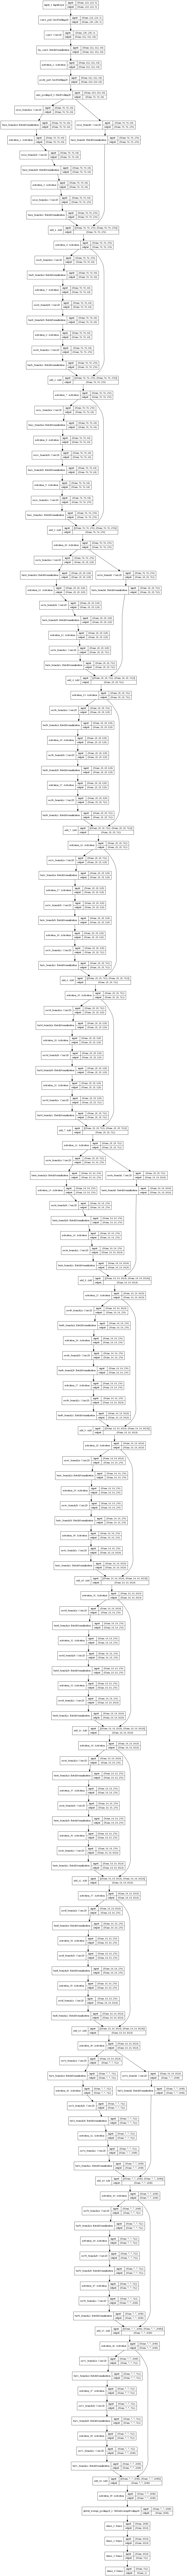

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, to_file='model_plot_resnet50.png', show_shapes=True, show_layer_names=True)

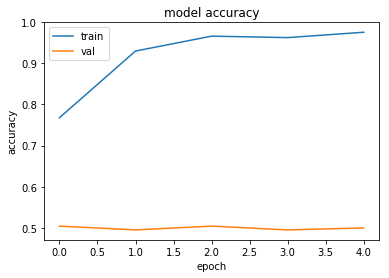

In [12]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

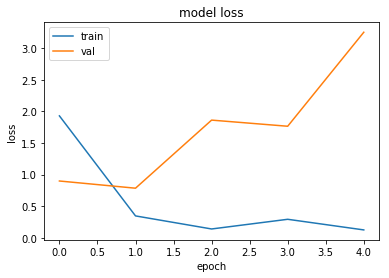

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()